In [44]:
import SimpleITK as sitk
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('../..')
from src.utils import crop_im

In [3]:
# Let's read in the example OAI image series to have a look at the metadata

# Load the image
oai_folder_path = '../../data/test_OAI_im/dicom_series/'
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(oai_folder_path)
reader.SetFileNames(dicom_names)
oai_volume = reader.Execute()

# Get the metadata
print("Image size:", oai_volume.GetSize())
print("Spacing (x, y, z):", oai_volume.GetSpacing())  # Includes pixel spacing and slice thickness
print("Origin:", oai_volume.GetOrigin())
print("Direction:", oai_volume.GetDirection())

Image size: (384, 384, 160)
Spacing (x, y, z): (0.36458333, 0.36458333, 0.6999999827242422)
Origin: (-31.153329, -81.383655, 70.0)
Direction: (0.2419219106304042, 0.0, -0.970295722528413, 0.970295722528413, 0.0, 0.2419219106304042, 0.0, -1.0000000000000002, 0.0)


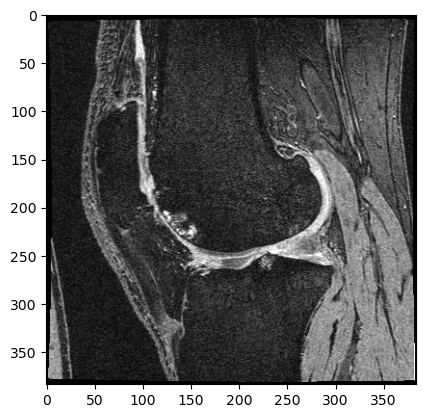

In [11]:
# plot the 100th slice
slice = sitk.GetArrayFromImage(oai_volume)[100, :, :]
plt.imshow(slice, cmap='gray', vmax=np.percentile(slice, 99.9))

In [13]:
# Now load the already-converted .nii.gz file
nii_path = '../../data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_001_0000.nii.gz'
nii_volume = sitk.ReadImage(nii_path)

# Get the metadata
print("Image size:", nii_volume.GetSize())
print("Spacing (x, y, z):", nii_volume.GetSpacing())  # Includes pixel spacing and slice thickness
print("Origin:", nii_volume.GetOrigin())
print("Direction:", nii_volume.GetDirection())


Image size: (256, 200, 160)
Spacing (x, y, z): (0.36500000953674316, 0.36500000953674316, 0.699999988079071)
Origin: (0.0, 0.0, 0.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


## only spacing was set - as 0.365, 0.365, 0.7

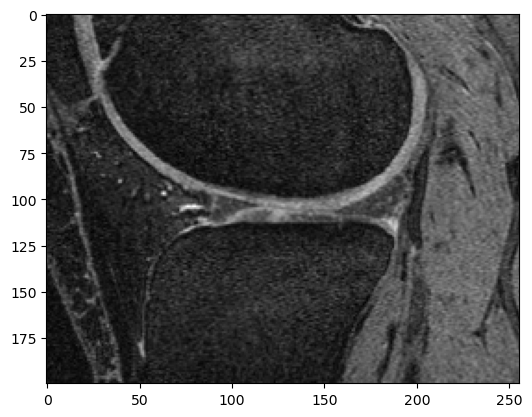

In [19]:
# Get slice 100
slice = sitk.GetArrayFromImage(nii_volume)[100, :, :]

# Plot the slice
plt.imshow(slice, cmap='gray')

In [15]:
# Look at how dimensions of numpy array are ordered
np_volume = sitk.GetArrayFromImage(nii_volume)
print("Numpy array shape:", np_volume.shape)

Numpy array shape: (160, 200, 256)


In [17]:
# Ok now load in original training image to compare
original_path = '../../data/IWOAI/train/train_001_V00.im'

# read in to numpy array using h5py
with h5py.File(original_path, 'r') as f:
    original_volume = np.array(f['data'])


In [42]:
# look at shape
print("Original shape:", original_volume.shape)

Original shape: (384, 384, 160)


In [25]:
# do cropping transformation
cropped_original = crop_im(original_volume)

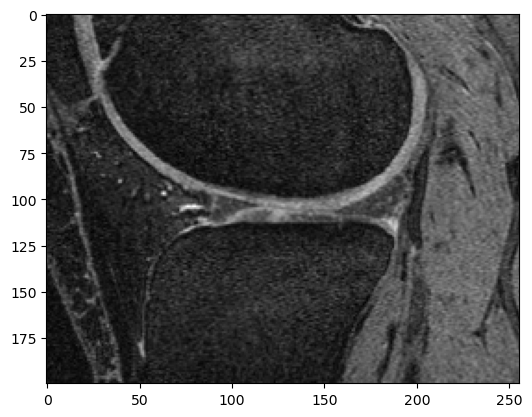

In [41]:
# plot the 100th slice
cropped_slice = cropped_original[:, :, 100]
plt.imshow(cropped_slice, cmap='gray')

In [29]:
# check all elements of both slices are the same
print(np.allclose(slice, cropped_slice))

True


In [30]:
# reorder dimensions of original volume, moving slice axis to front
reordered_original = np.moveaxis(cropped_original, -1, 0)

In [32]:
reordered_original.shape

(160, 200, 256)

In [33]:
# turn reordered original into sitk image
reordered_original_sitk = sitk.GetImageFromArray(reordered_original)

# check it is equal to nii volume 
np.array_equal(sitk.GetArrayFromImage(reordered_original_sitk), np_volume)

True

In [36]:
# set metadata of reordered original to be the same as nii volume
reordered_original_sitk.SetSpacing((0.365, 0.365, 0.70))

In [37]:
reordered_original_sitk.GetSpacing()

(0.365, 0.365, 0.7)

## Now transform test images and masks, and save in imagesTs and labelsTs

In [47]:
# data directory path
nnunet_data_dir = '../../data/nnUNet_raw/Dataset361_Menisci/'

# make labelsTs dir
os.makedirs(nnunet_data_dir + 'labelsTs', exist_ok=True)

# Get IWOAI test image and mask paths as sorted numpy arrays
test_image_dir = '../../data/IWOAI/test/'
test_mask_dir = '../../data/IWOAI/ground-truth/'

test_images = np.sort(np.array(glob.glob(test_image_dir + '*.im')))
test_masks = np.sort(np.array(glob.glob(test_mask_dir + '*.npy')))

In [52]:
# Write full loop to convert all test images and masks to .nii.gz format
# Then input spacing metadata
# Save to nnUNet_raw/Dataset361_Menisci/imagesTs and labelsTs
image_save_path = nnunet_data_dir + 'imagesTs/'
mask_save_path = nnunet_data_dir + 'labelsTs/'
spacing = (0.365, 0.365, 0.70)

for i in range(len(test_images)):
    # Load image
    with h5py.File(test_images[i], 'r') as f:
        test_image = np.array(f['data'])
    
    # Load mask, taking only the last mask
    test_mask = np.load(test_masks[i])[..., -1]
    
    # Crop image and mask
    cropped_image = crop_im(test_image)
    cropped_mask = crop_im(test_mask)
    
    # Reorder dimensions
    reordered_image = np.moveaxis(cropped_image, -1, 0)
    reordered_mask = np.moveaxis(cropped_mask, -1, 0)
    
    # Turn into sitk image
    sitk_image = sitk.GetImageFromArray(reordered_image)
    sitk_mask = sitk.GetImageFromArray(reordered_mask)
    
    # Set spacing
    sitk_image.SetSpacing(spacing)
    sitk_mask.SetSpacing(spacing)
    
    # Save image, padding number to always be 3 digits using zeros to the left
    sitk.WriteImage(sitk_image, image_save_path + f'IWOAI_{str(i+1).zfill(3)}_0000.nii.gz')
    
    # Save mask
    sitk.WriteImage(sitk_mask, mask_save_path + f'IWOAI_{str(i+1).zfill(3)}.nii.gz')

(0.36500000953674316, 0.36500000953674316, 0.699999988079071)
(0.36500000953674316, 0.36500000953674316, 0.699999988079071)
(160, 200, 256)
(160, 200, 256)


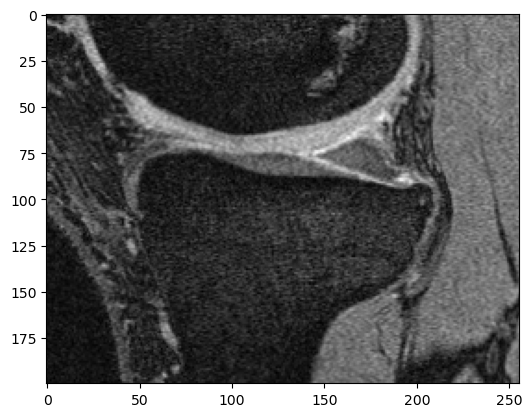

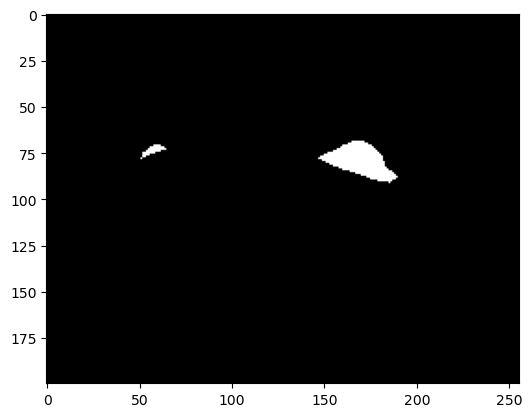

In [54]:
# check that the images and masks have been saved correctly by loading the first case of each
first_image = sitk.ReadImage(image_save_path + 'IWOAI_001_0000.nii.gz')
first_mask = sitk.ReadImage(mask_save_path + 'IWOAI_001.nii.gz')

# check that the spacing is correct
print(first_image.GetSpacing())
print(first_mask.GetSpacing())

# check that the shapes are correct
print(sitk.GetArrayFromImage(first_image).shape)
print(sitk.GetArrayFromImage(first_mask).shape)

# plot slice 100 of both
plt.imshow(sitk.GetArrayFromImage(first_image)[100, :, :], cmap='gray')
plt.show()
plt.imshow(sitk.GetArrayFromImage(first_mask)[100, :, :], cmap='gray')
plt.show()